# **Blackjack DQN**

**Rules:**
- Dealer gets one face down card, player gets one face up card
- Dealer gets one face up card, player gets one face up card
- Player hits, stays, or doubles (1 more hit)
- Repeat until stay or bust
- Play out dealers hand (hit if below 17)
- Winner is higher non-bust hand total
- Bet size is 2, payout is 2 for win, 3 for blackjack (payouts doubled if double was called)
- Assuming only one deck is used, shuffled after every game
- Aces are only 11s
- Ties are always 0 profit, even if blackjack was made with different numbers of cards

**Design:**
- Double DQN with policy network and target network
- input to network is batch of 104-length state tensors:
    - 52 values for visible player cards (0s or 1s, organized by number and within number organized by suit, clubs first then diamonds then hearts then spades)
    - 52 values for visible dealer card (same 0/1 encoding)
    - NOT keeping track of remaining cards in deck (for simplicity)
- output of network is batch of 3-length tensors w/ distribution of q-values over action space (estimated total value of taking each action)
    - 3 values for hit, stay, double
- standard epsilon-greedy exploration
- standard experience replay


In [55]:
# DQN structure

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(104, 16)
        self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, 3)
    
    def forward(self, x):  # x is a batch of state tensors, if only one state is input it must be 2-dimensional
        x.float()
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


In [56]:
# Experience Replay memory class
from collections import namedtuple, deque
import random

Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state'])

class ReplayMemory():

    def __init__(self, cap):
        self.memory = deque([], maxlen=cap)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [57]:
# model optimizer from experience replay

BATCH_SIZE = 100
GAMMA = 0.99  # discount of future expected value
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 20000  # number of randomly selected actions until epsilon decay has 1/e left (37%) 
TAU = 0.005  # portion of weights transferred to target net every update
LR = 1e-4

policy_net = DQN().to("cuda")
target_net = DQN().to("cuda")
target_net.load_state_dict(policy_net.state_dict())

memory = ReplayMemory(10000)
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

def optimize_dqn():
    # Only optimize when we have enough states in memory
    if len(memory) < BATCH_SIZE:
        return
    
    batch = memory.sample(BATCH_SIZE)  # List of transitions
    batch = Transition(*zip(*batch))  # Transition of lists

    next_state_mask = torch.tensor([ns is not None for ns in batch.next_state], device="cuda", dtype=torch.bool)
    

    sa_values = torch.gather(policy_net(torch.cat(batch.state)), dim=1, index=torch.cat(batch.action))
    exp_sa_values = torch.cat(batch.reward)

    existing_next_states = [s for s in batch.next_state if s is not None]

    if len(existing_next_states) > 0:       

        next_states = torch.cat(existing_next_states)

        with torch.no_grad():
            next_state_values = target_net(next_states).max(1).values.unsqueeze(1)

        exp_sa_values[next_state_mask] += GAMMA * next_state_values

    loss_func = nn.L1Loss()
    loss = loss_func(sa_values, exp_sa_values)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [58]:
# epsilon greedy action selection
import math

actions_taken = 0

def select_action(state):
    global actions_taken
    x = random.random()
    threshold = math.exp(-actions_taken/EPS_DECAY) * (EPS_START - EPS_END) + EPS_END
    actions_taken += 1
    if x <= threshold:  # Pick random action
        return torch.tensor([[random.randint(0, 2)]], device="cuda")
    else:  # Pick action with highest predicted Q-value
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)


In [59]:
# game state management

deck = []
p_up, d_up = set(), set()
d_hidden = -1
p_sum, d_sum = 0, 0


def get_state():
    p_tensor = torch.tensor([1 if card in p_up else 0 for card in range(52)], device="cuda", dtype=torch.float32)
    d_tensor = torch.tensor([1 if card in d_up else 0 for card in range(52)], device="cuda", dtype=torch.float32)
    return torch.cat((p_tensor, d_tensor)).unsqueeze(0)


def card_value(idx):  # 2s, then 3s, then..., then Ks, then As
    order = idx // 4 + 2
    if 11 <= order <= 13:  # Jacks, Queens, Kings
        return 10
    elif order == 14:  # Aces
        return 11
    else:
        return order


# Note: if player initially dealt two aces, even though they are busted they can still act, this won't affect result as they will still lose hand
def reset_game(override_deck=None):
    global deck, p_up, d_up, d_hidden, p_sum, d_sum
    p_up, d_up = set(), set()
    d_hidden = -1
    p_sum, d_sum = 0, 0

    if override_deck:
        deck = override_deck
    else:
        deck = [i for i in range(52)]
        random.shuffle(deck)

    # Set up game with top 4 cards    
    a, b, c, d = deck.pop(0), deck.pop(0), deck.pop(0), deck.pop(0)

    p_up.add(a)
    d_hidden = b
    p_up.add(c)
    d_up.add(d)

    p_sum += card_value(a) + card_value(c)
    d_sum += card_value(b) + card_value(d)

    return get_state()


def print_state():
    print(f"Dealer:   Facedown ({card_value(d_hidden)})   Up ({[card_value(c) for c in d_up]})")
    print(f"Player:   Up ({[card_value(c) for c in p_up]})")


def act(action):  # 0 = hit, 1 = stay, 2 = double
    global deck, p_up, d_up, d_hidden, p_sum, d_sum
    end, double = False, False
    reward = 0

    if action == 0:  # hit
        new = deck.pop(0)
        p_up.add(new)
        p_sum += card_value(new)
        if p_sum >= 21:
            end = True
    elif action == 1:  # stay
        end = True
    else:  # double
        new = deck.pop(0)
        p_up.add(new)
        p_sum += card_value(new)
        end = True
        double = True

    if end: 
        if p_sum > 21:  # bust
            base = -2
        else:
            while d_sum < 17:  # finish dealer's hand
                new = deck.pop(0)
                d_up.add(new)
                d_sum += card_value(new)
            if d_sum == p_sum:  # tie, no busts
                base = 0
            elif p_sum == 21:  # player blackjack, no tie
                base = 3
            elif d_sum > 21:  # only dealer busts
                base = 2
            elif p_sum < d_sum:  # dealer wins, no busts
                base = -2
            elif p_sum > d_sum:  # player wins, no busts
                base = 2
        
        reward = 2*base if double else base

    new_state = get_state() if not end else None
    return new_state, reward, end

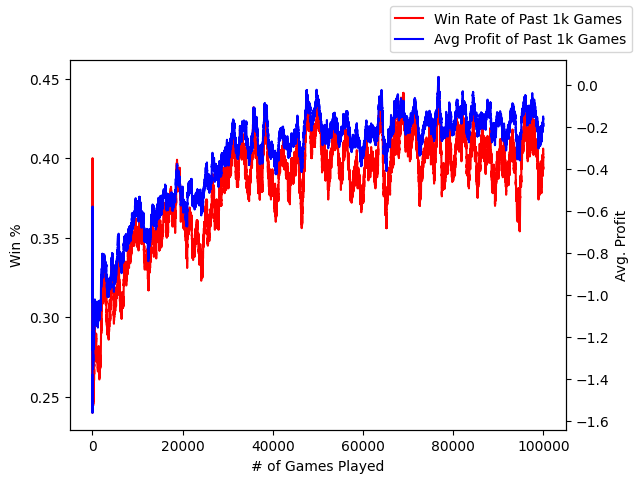

In [60]:
from matplotlib import pyplot as plt
from IPython import display

# episode iteration
NUM_GAMES = 100000
WIN_RATE_LENGTH = 1000
win_history = []
win_sum = 0
win_rates = []
profit_history = []
profit_sum = 0
avg_profits = []

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
legend = None

for g in range(1, NUM_GAMES+1):
    # in each episode:
    # - initialize random game state
    # - repeat: take action, push result to memory, optimize model, soft update target network
    # - until terminal game state
    # - record win/loss

    state = reset_game()

    for i in range(100):
        if i == 99:
            print("didn't break loop")
            break

        action = select_action(state)
        next_state, reward, end = act(action)
        reward = torch.tensor([[reward]], device="cuda", dtype=torch.float)
        memory.push(state, action, reward, next_state)
        state = next_state

        optimize_dqn()

        target_params = target_net.state_dict()
        policy_params = policy_net.state_dict()

        for k in policy_params:
            target_params[k] = (1-TAU) * target_params[k] + TAU * policy_params[k]
        
        target_net.load_state_dict(target_params)

        if end:
            if reward.item() > 0:
                result = 1
            else:
                result = 0
            
            win_history.append(result)
            win_sum += result
            if len(win_history) > WIN_RATE_LENGTH:
                oldest = win_history.pop(0)
                win_sum -= oldest
            win_rates.append(win_sum/min(g, WIN_RATE_LENGTH))

            profit_history.append(reward.item())
            profit_sum += reward.item()
            if len(profit_history) > WIN_RATE_LENGTH:
                oldest = profit_history.pop(0)
                profit_sum -= oldest
            avg_profits.append(profit_sum/min(g, WIN_RATE_LENGTH))

            if g % 20 == 0:
                # clear old axes/legend
                ax1.cla()
                ax2.cla()
                if legend:
                    legend.remove()

                # set axis labels
                ax1.set_xlabel('# of Games Played')
                ax1.set_ylabel('Win %')
                ax2.set_ylabel('Avg. Profit')
                ax2.yaxis.set_label_position("right")

                # plot updated data w/ legend
                ax1.plot(win_rates[20:], color="r", label='Win Rate of Past 1k Games')
                ax2.plot(avg_profits[20:], color="b", label='Avg Profit of Past 1k Games')
                legend = fig.legend()

                # redraw figure
                display.display(fig)
                display.clear_output(wait=True)
            
            break

In [61]:
## Baseline strategy (double 10/11, hit <17, stay otherwise)
# baseline_win_history = []
# baseline_win_sum = 0
# baseline_win_rates = []
# baseline_profit_history = []
# baseline_profit_sum = 0
# baseline_avg_profits = []

# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# legend = None

# for g in range(1, NUM_GAMES+1):

#     state = reset_game()

#     for i in range(100):
#         if i == 99:
#             print("didn't break loop")
#             break

#         action = 2 if p_sum == 11 or p_sum == 10 else 0
#         if p_sum >= 17:
#             action = 1

#         _, reward, end = act(action)

#         if end:
#             if reward > 0:
#                 result = 1
#             else:
#                 result = 0
            
#             baseline_win_history.append(result)
#             baseline_win_sum += result
#             if len(baseline_win_history) > WIN_RATE_LENGTH:
#                 oldest = baseline_win_history.pop(0)
#                 baseline_win_sum -= oldest
#             baseline_win_rates.append(baseline_win_sum/min(g, WIN_RATE_LENGTH))

#             baseline_profit_history.append(reward)
#             baseline_profit_sum += reward
#             if len(baseline_profit_history) > WIN_RATE_LENGTH:
#                 oldest = baseline_profit_history.pop(0)
#                 baseline_profit_sum -= oldest
#             baseline_avg_profits.append(baseline_profit_sum/min(g, WIN_RATE_LENGTH))


#             if g % 20 == 0:
#                 # clear old axes/legend
#                 ax1.cla()
#                 ax2.cla()
#                 if legend:
#                     legend.remove()

#                 # set axis labels
#                 ax1.set_xlabel('# of Games Played')
#                 ax1.set_ylabel('Win %')
#                 ax2.set_ylabel('Avg. Profit')
#                 ax2.yaxis.set_label_position("right")

#                 # plot updated data w/ legend
#                 ax1.plot(baseline_win_rates[20:], color="r", label='Win Rate of Past 1k Games')
#                 ax2.plot(baseline_avg_profits[20:], color="b", label='Avg Profit of Past 1k Games')
#                 legend = fig.legend()

#                 # redraw figure
#                 display.display(fig)
#                 display.clear_output(wait=True)
#             break

In [62]:
# Test trained model against baseline for 5k games on the SAME INITIAL STATES

TEST_SIZE = 100000
dqn_profit, baseline_profit = 0, 0
dqn_wins, baseline_wins = 0, 0

for game in range(TEST_SIZE):

    if game % (TEST_SIZE // 10) == 0:
        print(f"Testing on game {game+1}")

    random_deck = [i for i in range(52)]
    random.shuffle(random_deck)

    ##################################
    #      Testing DQN strategy      #
    ##################################
    
    state = reset_game(random_deck)

    for i in range(100):
        if i == 99:
            print("didn't break loop dqn")
            break

        with torch.no_grad():
            action = policy_net(state).max(1).indices.view(1, 1)
        next_state, reward, end = act(action)
        state = next_state

        if end:
            if reward > 0:
                dqn_wins += 1
            
            dqn_profit += reward
            break
    
    ##################################
    #   Testing baseline strategy    #
    ##################################

    state = reset_game(random_deck)

    for i in range(100):
        if i == 99:
            print("didn't break loop baseline")
            break

        action = 2 if p_sum == 11 or p_sum == 10 else 0
        if p_sum >= 17:
            action = 1

        _, reward, end = act(action)

        if end:
            if reward > 0:
                baseline_wins += 1
            
            baseline_profit += reward
            break

print("\nResults:")
print(f"DQN win rate: {dqn_wins/TEST_SIZE}")
print(f"Baseline win rate: {baseline_wins/TEST_SIZE}")
print(f"DQN avg profit: {dqn_profit/TEST_SIZE}")
print(f"Baseline avg profit: {baseline_profit/TEST_SIZE}")
        

Testing on game 1
Testing on game 10001
Testing on game 20001
Testing on game 30001
Testing on game 40001
Testing on game 50001
Testing on game 60001
Testing on game 70001
Testing on game 80001
Testing on game 90001

Results:
DQN win rate: 0.41447
Baseline win rate: 0.40604
DQN avg profit: -0.07523
Baseline avg profit: -0.05081


(baseline is the same in each test, just showing numbers each time to give an idea of the variance)

## 3 layers:

16 neurons: DQN 41.8% win rate, -0.19 avg profit; Baseline 40.3% win rate, -0.06 avg profit

128 neurons: DQN 41.0% win rate, -0.14 avg profit; Baseline 40.5% win rate, -0.05 avg profit

## 4 layers:

16 neurons: DQN 41.1% win rate, -0.18 avg profit; Baseline 40.6% win rate, -0.05 avg profit

128 neurons: DQN 39.8% win rate, -0.21 avg profit; Baseline 40.7% win rate, -0.05 avg profit 

# With 100000 training games:

16 neurons, 3 layers: DQN 41.4% win rate, -0.08 avg profit; Baseline 40.6% win rate, -0.05 avg profit

16 neurons, 4 layers: DQN 41.9% win rate, -0.07 avg profit; Baseline 40.5% win rate, -0.06 avg profit

128 neurons, 4 layers: DQN 41.6% win rate, -0.09 avg profit; Baseline 40.7% win rate, -0.05 avg profit

# Thoughts:
- I decreased neurons in middle layer from 128, each time seeing a slight improvement in win rate outperformance of the baseline. Profit stayed worse, though, which is what the DQN should be optimizing for.
- Seems like simpler works better, a neural network overcomplicates the strategy such that it performs worse, and the simpler structure of the net, the better it does.